In [1]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from scipy import ndimage

In [2]:
def place_in_img(img, new, center_loc, ref_scale=1, rotation_angle=0):

    if ref_scale != 1:
        new_shape = (np.array(new.shape)*ref_scale).astype('int')
        new = cv2.resize(new, new_shape[::-1])
    if rotation_angle != 0:
        new = ndimage.rotate(new, rotation_angle, mode='constant', cval=0)

    
    img_sx = center_loc[1] - (new.shape[1] // 2)
    left_crop = max(0 - img_sx, 0)
    
    img_ex = img_sx + new.shape[1]
    right_crop = min(img.shape[1] - img_ex, 0)

    img_sy = center_loc[0] - (new.shape[0] // 2)
    top_crop = max(0 - img_sy, 0)
    
    img_ey = img_sy + new.shape[0]
    bott_crop = min(img.shape[0] - img_ey, 0)
    
    img_sx = max(img_sx, 0)
    img_ex = min(img_ex, img.shape[1])
    img_sy = max(img_sy, 0)
    img_ey = min(img_ey, img.shape[0])

    if img_ex < 0:
        img_ex = 0
    if img_sx > img.shape[1]:
        img_sx = img.shape[1]
    if img_ey < 0:
        img_ey = 0
    if img_sy > img.shape[0]:
        img_sy = img.shape[0]

    img[img_sy:img_ey,img_sx:img_ex] = new[top_crop:new.shape[0]+bott_crop, left_crop:new.shape[1]+right_crop]
    return img


In [3]:
DEBUG = False
mask_metadata_fps = sorted(glob('../2_live_bees/3_card_mask_matches_metadata/*'))
for mask_metadata_fp in tqdm(mask_metadata_fps):
    reference = cv2.imread('../2_live_bees/type_mask_Hive01_Sheet_01_slide17_left.png', cv2.IMREAD_GRAYSCALE)
    fn = mask_metadata_fp.split('/')[-1]
    if os.path.exists('../2_live_bees/4_segs/'+fn.replace('.json','.png')):
        continue
    
    card_metadata_fp = '../2_live_bees/1_metadata/' + fn
    with open(mask_metadata_fp, 'r') as f:
        metadata = json.load(f)
    with open(card_metadata_fp, 'r') as f:
        card_metadata = json.load(f)
    metadata.update(card_metadata)
    
    card_angle = metadata['card_angle']
    card_rotated_x_start = metadata['card_rotated_x_start']
    card_rotated_x_end = metadata['card_rotated_x_end']
    ref_pos = metadata['registration_pos']
    ref_pos_in_rotated_orig = [ref_pos[0], ref_pos[1] + card_rotated_x_start]
    ref_scale = metadata['registration_scale']
    ref_angle = metadata['registration_angle']
    
    is_facing_up = metadata['is_facing_up?']
    if not is_facing_up:
        reference = np.flipud(reference)
    

    date = '_'.join(fn.split('_')[:3])
    bee_id = fn.split('_')[-1].split('.')[0]
    
    img_fp = glob(f'../WWBEE24_images/*/*/{date}/{bee_id}*')[0]
    mask_fp = '../2_live_bees/2_final_masks/' + fn.replace('.json','.png')

    
    img = cv2.imread(img_fp)
    mask = cv2.imread(mask_fp, cv2.IMREAD_GRAYSCALE)
    
    rotated = ndimage.rotate(img, card_angle, mode='constant', cval=255)

    full_mask = np.zeros(rotated.shape[:2]).astype('uint8')
    full_mask[:,card_rotated_x_start:card_rotated_x_end] = mask
    mask_start_x = np.where(full_mask > 0.5)[1].min()
    
    if DEBUG:
        plt.figure()
        plt.imshow(full_mask)
    
    if DEBUG:
        plt.figure()
        plt.imshow(full_mask[:,mask_start_x:])
    
    full_ref = np.zeros(rotated.shape[:2]).astype('uint8')
    full_ref = place_in_img(full_ref, reference, ref_pos_in_rotated_orig, ref_scale, ref_angle)

    combined_full_mask = np.zeros(rotated.shape[:2]).astype('uint8')
    combined_full_mask[full_mask > 0.5] = 100
    combined_full_mask[:,:mask_start_x] = full_ref[:,:mask_start_x]

    full_seg = np.ones(rotated.shape).astype('uint8')*255
    full_seg[combined_full_mask > 0.5] = rotated[combined_full_mask > 0.5]

    sy, sx = np.array(np.where(combined_full_mask > 0.5)).min(axis=1)
    ey, ex = np.array(np.where(combined_full_mask > 0.5)).max(axis=1)
    combined_mask = combined_full_mask[sy:ey,sx:ex]
    seg = full_seg[sy:ey,sx:ex]

    cv2.imwrite('../2_live_bees/4_masks/'+fn.replace('.json','.png'), combined_mask)
    cv2.imwrite('../2_live_bees/4_segs/'+fn.replace('.json','.png'), seg)
    
    
    if DEBUG:
        plt.figure()
        plt.imshow(combined_full_mask)
    
    if DEBUG:
        plt.figure()
        plt.imshow(seg)
    if DEBUG:
        plt.figure()
        plt.imshow(full_seg)
    
    
    if DEBUG:
        plt.figure()
        plt.imshow(full_ref)
    
    if DEBUG:
        break
metadata

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [05:07<00:00,  2.67s/it]


{'registration_ref': '../2_live_bees/type_mask_Hive01_Sheet_01_slide17_left.png',
 'registration_pos': [1920, 440],
 'registration_angle': -7.6989949812919365,
 'registration_scale': 2.2151189640830538,
 'registration_score': 0.9531714721512716,
 'is_facing_up?': True,
 'wing_side': 'right',
 'card_angle': -0.24999999999999717,
 'card_rotated_x_start': 2408,
 'card_rotated_x_end': 3896}

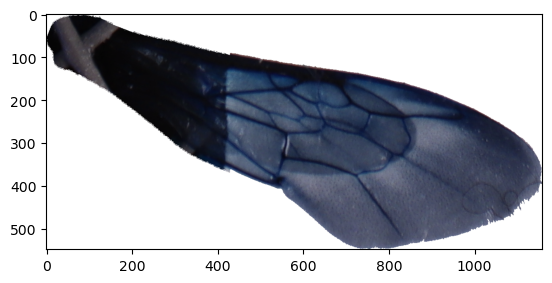

In [71]:
plt.imshow(seg)

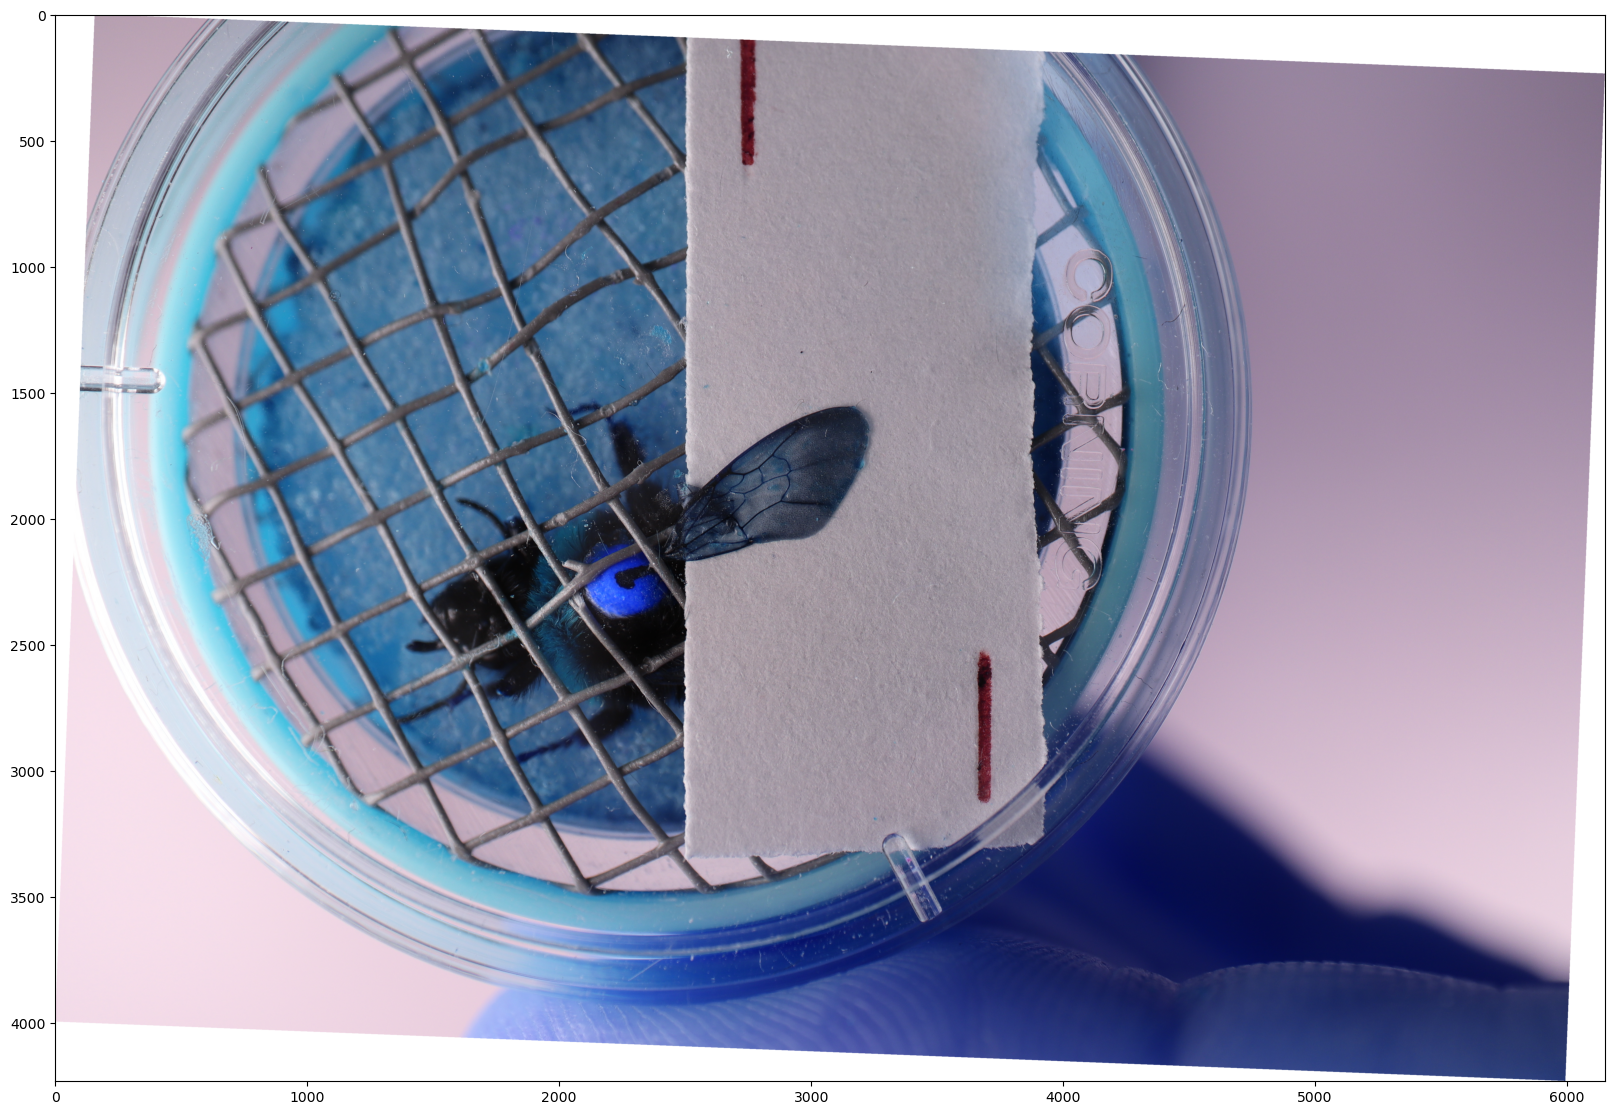

In [55]:
plt.figure(figsize=(20,20))
plt.imshow(rotated)

In [62]:
np.array(np.where(combined_full_mask > 0.5)).min(axis=1)

array([1552, 2114])